Classical Protein Folding

In [1]:
import numpy as np 
import pandas as pd
import time as time
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

In [2]:
aminoAcid = 300 # Number of Amino Acid
def RandDivision(aminoAcid):
    hydrophobic = np.random.randint(1, aminoAcid)
    polar = aminoAcid - hydrophobic
    aminoacids = ['H'] * hydrophobic + ['P'] * polar
    np.random.shuffle(aminoacids)
    return hydrophobic, polar, aminoacids

In [3]:
def DetermineDirection(preRow, preCol, curRow, curCol):
    """
    Determines the cardinal direction of the current move in comparison to the previous move.
    """
    cmv = (curRow - preRow, curCol - preCol)
    vectors = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }
    for direction, vector in vectors.items():
        if cmv == vector:
            return direction
    return None

In [4]:
def DeterministicNeighbors(lRow, lCol, relativeDirection):
    """
    Determine neighbors based on a "left, middle, right" heuristic, always prioritizing left.
    The 'relative_direction' parameter indicates the direction relative to the last move.
    """
    if relativeDirection == 'down':
        # Moving down: left is right on the grid, right is left on the grid
        left = (lRow, lCol + 1)  # Right on the grid
        middle = (lRow + 1, lCol)  # Down
        right = (lRow, lCol - 1)  # Left on the grid
    elif relativeDirection == 'up':
        # Moving up: left is left on the grid, right is right on the grid
        left = (lRow, lCol - 1)  # Left on the grid
        middle = (lRow - 1, lCol)  # Up
        right = (lRow, lCol + 1)  # Right on the grid
    elif relativeDirection == 'left':
        # Moving left: left is down on the grid, right is up on the grid
        left = (lRow + 1, lCol)  # Down
        middle = (lRow, lCol - 1)  # Left
        right = (lRow - 1, lCol)  # Up
    else:  # relative_direction == 'right'
        # Moving right: left is up on the grid, right is down on the grid
        left = (lRow - 1, lCol)  # Up
        middle = (lRow, lCol + 1)  # Right
        right = (lRow + 1, lCol)  # Down
    neighbors = [left, middle, right]
    return neighbors

In [5]:
def PlaceAminoAcid(grid, aminoAcidC, aminoAcidO, btCount, lastAminoR=None, lastAminoC=None, btED=0, fenced=None, fenceLim=0, fences=0, acidsPlaced=0):
    gSize = len(grid)
    # Base case: if no amino acids left, return True
    if not aminoAcidC:
        return True, btCount
    # For the first amino acid
    if lastAminoR is None or lastAminoC is None:
        firstAminoR = gSize // 2
        firstAminoC = gSize // 2
        aaType = aminoAcidC.pop(0)
        grid[firstAminoR, firstAminoC] = aaType
        aminoAcidO.append((aaType, (firstAminoR, firstAminoC)))
        return PlaceAminoAcid(grid, aminoAcidC, aminoAcidO, btCount, firstAminoR, firstAminoC, btED, fenced, fenceLim, fences, acidsPlaced)
    # Handling all other acids
    neighbors = [
        (lastAminoR - 1, lastAminoC),
        (lastAminoR + 1, lastAminoC),
        (lastAminoR, lastAminoC - 1),
        (lastAminoR, lastAminoC + 1)
    ]
    valNeighbors = [(row, col) for row, col in neighbors if 0 <= row < gSize and 0 <= col < gSize and grid[row, col] == '']
    np.random.shuffle(valNeighbors)
    aaType = aminoAcidC.pop(0)
    if len(valNeighbors) > 0:
        grid[valNeighbors[0][0], valNeighbors[0][1]] = aaType
        aminoAcidO.append((aaType, (valNeighbors[0][0], valNeighbors[0][1])))
        acidsPlaced += 1  # Increment acid placement counter
        return PlaceAminoAcid(grid, aminoAcidC, aminoAcidO, btCount, valNeighbors[0][0], valNeighbors[0][1], 0, fenced, fenceLim, fences, acidsPlaced)  # Recursive call
    else:
        # Backtracking logic
        btCount += 1
        btED = 1
        fenceLim += 1
        aminoAcidC.insert(0, aaType)
        grid[lastAminoR, lastAminoC] = ''
        aminoAcidO.pop()
        # Remove fences if the number of acids placed exceeds the number of fences
        if acidsPlaced > fences:
            # Remove all fences
            for i in range(gSize):
                for j in range(gSize):
                    if grid[i, j] == 'F':
                        grid[i, j] = ''
            fences = 0  # Reset fence count
        # Reset acid placement counter after backtracking
        acidsPlaced = 0
        if not aminoAcidO:  # If all acids have been removed, return failure
            return False, btCount
        # Repeat the process for the last acid in the order
        _, (prevR, prevC) = aminoAcidO[-1]
        return PlaceAminoAcid(grid, aminoAcidC, aminoAcidO, btCount, prevR, prevC, btED, fenced, fenceLim, fences, acidsPlaced)
    # If no neighbors lead to a solution, return False
    return False, btCount

In [6]:
def InitGrid(aminoAcids, hydrophobics, polars):
    aminoAcidC = aminoAcids.copy()
    amniAcidCount = len(aminoAcids)
    grid_size = amniAcidCount * 2
    grid = np.full((grid_size, grid_size), fill_value='', dtype=object)
    aminoAcidO = []
    _, btCount = PlaceAminoAcid(grid, aminoAcidC, aminoAcidO, 0)
    return grid, aminoAcidO, btCount

In [7]:
def DetermineDirections(aminoAcidO):
    """
    Determines the direction of each amino acid placement relative to the previous one.
    Directions are 'left', 'straight', 'right', considering the orientation of the movement from the previous point.
    """
    directions = ['start']  # First amino acid has no direction
    # Define movement vectors for easier comparison
    mv = {
        'up': (-1, 0),
        'down': (1, 0),
        'left': (0, -1),
        'right': (0, 1)
    }
    for i in range(1, len(aminoAcidO)):
        # Get the current and previous amino acid's row and column
        _, (cR, cC) = aminoAcidO[i]
        _, (pR, pC) = aminoAcidO[i - 1]
        # Determine the movement vector from the previous amino acid
        mV = (cR - pR, cC - pC)
        if i == 1:
            # For the second amino acid, we don't have a previous direction, so we set it as straight
            direction = 'straight'
        else:
            # Get the previous movement vector
            _, (ppR, ppC) = aminoAcidO[i - 2]
            pmV = (pR - ppR, pC - ppC)
            # Determine direction based on previous movement vector
            if pmV in [mv['up'], mv['down']]:
                # Moving vertically
                if mV == mv['left']:
                    direction = 'left' if pmV == mv['up'] else 'right'
                elif mV == mv['right']:
                    direction = 'right' if pmV == mv['up'] else 'left'
                else:
                    direction = 'straight'
            else:
                # Moving horizontally
                if mV == mv['up']:
                    direction = 'left' if pmV == mv['right'] else 'right'
                elif mV == mv['down']:
                    direction = 'right' if pmV == mv['right'] else 'left'
                else:
                    direction = 'straight'
        directions.append(direction)
    return directions

In [8]:
def TrimGrid(grid):
    nonEmptyR = np.any(grid != '', axis=1)
    nonEmptyC = np.any(grid != '', axis=0)
    tGrid = grid[nonEmptyR][:, nonEmptyC]
    return tGrid

In [9]:
def Find_H_PairsGrid(grid):
    adjacentH_AA = set()
    for row in range(grid.shape[0]):
        for col in range(grid.shape[1]):
            cA = grid[row, col]
            if cA == 'H':
                # Check the neighboring positions (up, down, left, right) relative to the current position
                neighbors = [
                    (row - 1, col),
                    (row + 1, col),
                    (row, col - 1),
                    (row, col + 1)
                ]
                for nRow, nColumn in neighbors:
                    # Check if the neighbor is within the grid bounds
                    if 0 <= nRow < grid.shape[0] and 0 <= nColumn < grid.shape[1]:
                        nA = grid[nRow, nColumn]
                        # Check if the neighbor is also 'H'
                        if nA == 'H':
                            # Use frozenset to ensure that the order of coordinates doesn't matter
                            aminoAcidPair = frozenset({(row, col), (nRow, nColumn)})
                            adjacentH_AA.add(aminoAcidPair)                      
    return adjacentH_AA

In [10]:
def Find_H_PairsOrder(aminoAcidO):
    adjacentH_AA = set()  
    for i in range(len(aminoAcidO) - 1):
        cA, current_position = aminoAcidO[i]
        nextA, nPosition = aminoAcidO[i + 1]
        if cA == 'H' and nextA == 'H':
            amino_acid_pair = frozenset({current_position, nPosition})
            adjacentH_AA.add(amino_acid_pair)
    return adjacentH_AA

In [11]:
def Calculate_H_Bonds(grid, aminoAcidO):
    gridHPairs = Find_H_PairsGrid(grid)
    orderHPairs = Find_H_PairsOrder(aminoAcidO)
    return gridHPairs - orderHPairs

In [12]:
def GenerateSamples(N, aminoAcidCount):
    samples = []
    for _ in range(N):
        hydrophobics, polars, aminoAcids = RandDivision(aminoAcidCount)
        print("Amino Acid String:", "".join(aminoAcids))
        aminoAcidC = aminoAcids.copy()
        initGrid, aminoAcidO, btCount = InitGrid(aminoAcidC, hydrophobics, polars)
        tGrid = TrimGrid(initGrid)
        proteinDim = tGrid.shape
        aminoAcidGrid = np.count_nonzero(initGrid != '')
        aminoAcidDirections =  DetermineDirections(aminoAcidO)
        hbonds = len(Calculate_H_Bonds(initGrid, aminoAcidO))
        hratio = hbonds / aminoAcidGrid
        backtracks = btCount
        samples.append((hydrophobics,
                               polars,
                               aminoAcids,
                               initGrid,
                               aminoAcidGrid,
                               aminoAcidO,
                               aminoAcidDirections,
                               tGrid, 
                               proteinDim,
                               hbonds,
                               hratio,
                               backtracks,
                              ))
    return samples,"".join(aminoAcids)


def Visualize(aminoAcidO):
    _, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    color_map = {'H': 'purple', 'P': 'grey', '': 'white'}
    size_map = {'H': 150, 'P': 150, '': 0}  
    arrow_properties = dict(facecolor='black', edgecolor='red', width=0.07, head_width=0.5, head_length=0.2, lw=0.2)
    positions = np.array([(pos[1], pos[0]) for _, pos in aminoAcidO])  # Reversing coordinates for correct plotting
    if len(positions) > 1:  
        for i in range(1, len(positions)):
            ax.arrow(positions[i-1][0], -positions[i-1][1], positions[i][0] - positions[i-1][0], -(positions[i][1] - positions[i-1][1]),
                     **arrow_properties, length_includes_head=True, zorder=3)
    for type_pos in aminoAcidO:
        aa_type, (aa_row, aa_col) = type_pos
        ax.scatter(aa_col, -aa_row, s=size_map[aa_type], c=color_map[aa_type], zorder=2)
        ax.text(aa_col, -aa_row, aa_type, color='white', ha='center', va='center', fontsize=12, zorder=3)
    if len(positions) > 0:
        x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
        y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
        ax.set_xlim(x_min - 5, x_max + 5)
        ax.set_ylim(-y_max - 5, -y_min + 5)
    ax.axis('off')   
    plt.show()

Amino Acid String: HHHPP
created and processed 1 samples for amino acid length of 5 using Intel Core i7-11800H @ 2.30GHz: 0.00 seconds


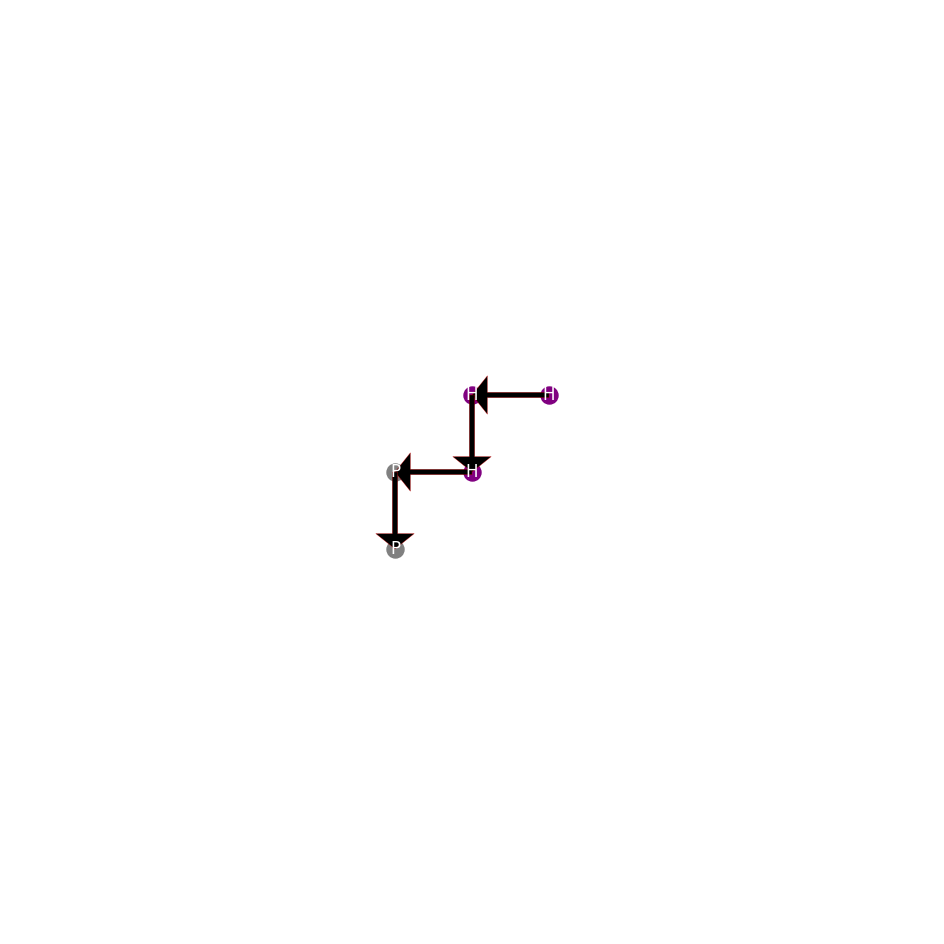

[('H', (5, 5)), ('H', (5, 4)), ('H', (6, 4)), ('P', (6, 3)), ('P', (7, 3))]

In [14]:
N = 1
AACount = 5 # Amino Acid Count
start_time = time.time()
sample, aminoAcids = GenerateSamples(1, AACount)
end_time = time.time()
total_time = end_time - start_time
print(f"created and processed {N} samples for amino acid length of {AACount} using Intel Core i7-11800H @ 2.30GHz: {total_time:.2f} seconds")
Visualize(sample[0][5])
sample[0][5]

--------------------------------------------------------------

Quantum Protein Folding

In [18]:
import matplotlib.lines as mlines
import dimod
import matplotlib.pyplot as plt
import dynex

In [19]:
# Protein sequence and grid dimensions
#sequence = "HPPHHPPPHPHHPHPHHPHP" # HP = 20
sequence = "HPPHH" # HP = 5


N = len(sequence)
L = (len(sequence) // 2) + 1  # Assuming a 5x5 grid for simplicity

# Create binary variables for each bead at each grid point (checkerboard pattern)
variables = {(i, j, k): f"x_{i}_{j}_{k}" for i in range(N) for j in range(L) for k in range(L)
             if (j + k) % 2 == i % 2}  # Even/Odd site placement based on bead index

# Define the interaction matrix for the HP model
def interaction(h1, h2):
    return -1 if h1 == 'H' and h2 == 'H' else 0

# Initialize the QUBO dictionary
Q = {}

# Add HP energy terms
for f in range(N):
    for fp in range(f + 2, N):  # Ensure non-adjacent beads in sequence
        if interaction(sequence[f], sequence[fp]) != 0:
            for j in range(L):
                for k in range(L):
                    for jp in range(L):
                        for kp in range(L):
                            if abs(j - jp) + abs(k - kp) == 1:  # Neighbors on the grid
                                if (j + k) % 2 == f % 2 and (jp + kp) % 2 == fp % 2:  # Correct sites
                                    pair = (variables[f, j, k], variables[fp, jp, kp])
                                    if pair in Q:
                                        Q[pair] += interaction(sequence[f], sequence[fp])
                                    else:
                                        Q[pair] = interaction(sequence[f], sequence[fp])

# Constraint to ensure each bead is placed at exactly one location
for i in range(N):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:
                one_site = [variables[i, jp, kp] for jp in range(L) for kp in range(L) if (jp + kp) % 2 == i % 2 and (jp, kp) != (j, k)]
                for var in one_site:
                    Q[(variables[i, j, k], var)] = Q.get((variables[i, j, k], var), 0) + 2  # Quadratic penalty for being at multiple locations

# Enhanced self-avoidance constraint
for j in range(L):
    for k in range(L):
        beads = [variables[i, j, k] for i in range(N) if (i, j, k) in variables]
        if len(beads) > 1:  # Only necessary if more than one bead could occupy this site
            for b1 in range(len(beads)):
                for b2 in range(b1 + 1, len(beads)):
                    Q[(beads[b1], beads[b2])] = Q.get((beads[b1], beads[b2]), 0) + 10  # Significantly increased penalty for overlap

# Add the connectivity constraint between consecutive beads with increased penalty
for i in range(N - 1):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:  # Even or odd site based on the bead index
                possible_next_positions = [(jp, kp) for jp in range(L) for kp in range(L)
                                           if abs(j - jp) + abs(k - kp) == 1 and (jp + kp) % 2 == (i + 1) % 2]
                if possible_next_positions:  # Ensure there are possible positions
                    next_bead_vars = [variables[i + 1, jp, kp] for jp, kp in possible_next_positions]
                    # Apply a stronger penalty if not adjacent
                    for next_var in next_bead_vars:
                        Q[(variables[i, j, k], next_var)] = Q.get((variables[i, j, k], next_var), 0) - 3  # Negative for attraction



# Create the Binary Quadratic Model
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)


# ------------- Classical Simulated Annealing Sampler -------------
#sampler = dimod.SimulatedAnnealingSampler()
#sampleset = sampler.sample(bqm, num_reads=100)


# ------------- Dynex -------------
model = dynex.BQM(bqm)
sampler = dynex.DynexSampler(model, mainnet=True, description='Quantum Protein Folding')
sampleset = sampler.sample(num_reads=1000, annealing_time=100, debugging=False)



lowest_energy_sample = sampleset.first.sample

# Extract the positions of the beads from the variable names in the lowest energy sample
positions = {}
for variable_name, value in lowest_energy_sample.items():
    if value == 1:
        # The variable name format is "x_i_j_k", we need to extract i, j, k
        parts = variable_name.split('_')
        i = int(parts[1])
        j = int(parts[2])
        k = int(parts[3])
        positions[i] = (j, k)

positions

╭────────────┬─────────────┬───────────┬────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CHIPS │   STEPS │   GROUND STATE │
├────────────┼─────────────┼───────────┼────────────────┼─────────┼─────────┼────────────────┤
│       7905 │        0.09 │      2.33 │              2 │    1984 │     100 │        1400.00 │
╰────────────┴─────────────┴───────────┴────────────────┴─────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬─────────┬───────┬──────────┬───────────────┬─────────────────────────────┬───────────┬──────────╮
│     WORKER │         VERSION │   CHIPS │   LOC │   ENERGY │       RUNTIME │                 LAST UPDATE │     STEPS │   STATUS │
├────────────┼─────────────────┼─────────┼───────┼──────────┼───────────────┼─────────────────────────────┼───────────┼──────────┤
│ e52e..11e4 │ 2.3.5.OZM.132.L │ 6053440 │     0 │     0.00 │  13.02858121s │ 2024-05-06T21:39:17.493301Z │ 0 (0.00%) │  STOPPED │
├

{0: (1, 1), 1: (1, 0), 2: (2, 0), 3: (2, 1), 4: (2, 2)}

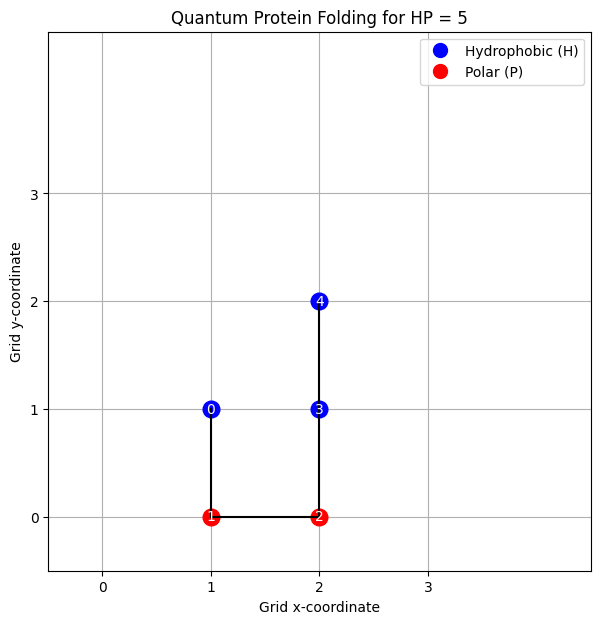

In [20]:
# Create a plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks(range(L+1))
ax.set_yticks(range(L+1))
ax.grid(True)

# Define colors for hydrophobic (H) and polar (P) beads
colors = {'H': 'blue', 'P': 'red'}

# Plot each bead in the sequence and connect with lines
for index in range(len(positions)):
    j, k = positions[index]
    color = colors[sequence[index]]
    ax.plot(j, k, 'o', markersize=12, color=color)  # Plot points
    ax.text(j, k, f'{index}', color='white', ha='center', va='center')  # Label points

    # Draw lines between sequential beads
    if index > 0:
        prev_j, prev_k = positions[index - 1]
        ax.plot([prev_j, j], [prev_k, k], color='black') 
hydrophobic_legend = mlines.Line2D([], [], color='blue', marker='o',
                                   markersize=10, label='Hydrophobic (H)', linestyle='None')
polar_legend = mlines.Line2D([], [], color='red', marker='o',
                             markersize=10, label='Polar (P)', linestyle='None')
ax.legend(handles=[hydrophobic_legend, polar_legend])
ax.set_xlabel('Grid x-coordinate')
ax.set_ylabel('Grid y-coordinate')
ax.set_title('Quantum Protein Folding for HP = 5')
plt.show()